<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prep-data" data-toc-modified-id="Prep-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prep data</a></span><ul class="toc-item"><li><span><a href="#Selecting-features" data-toc-modified-id="Selecting-features-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Selecting features</a></span></li><li><span><a href="#Dealing-with-NaNs" data-toc-modified-id="Dealing-with-NaNs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dealing with NaNs</a></span></li><li><span><a href="#Init-run_model_DX-function" data-toc-modified-id="Init-run_model_DX-function-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Init <code>run_model_DX</code> function</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Without-scaling-the-objective" data-toc-modified-id="Without-scaling-the-objective-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Without scaling the objective</a></span></li><li><span><a href="#Scaling-the-objective" data-toc-modified-id="Scaling-the-objective-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scaling the objective</a></span></li></ul></li></ul></div>

In [3]:
! pip install shap -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 10.6 MB/s eta 0:00:00


# Prep data

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss, classification_report
import shap
import pickle
#from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH = '/content/drive/MyDrive/inmunodiagnosis_ML/'
#PATH = "/Users/josealfredomendezbarrera/Documents/prsnl/who_is_your_data/"

In [7]:
minimun_wordfreq=800
BASE = "data/USIDNET_reducida_04a"

ds_tastingmovies = pd.read_csv(PATH + BASE + ".csv")

In [8]:
ds_tastingmovies.head()

,id_px,Category,Allergic rhinitis,Congenital heart disease,Cardiovascular disease,Autoimmune (any),Heart infection,Constitutional symptoms,Bleeding,Palate,...,I_Alto_EOSINOFILOS,I_Alto_IgA,I_Alto_IgE,I_Alto_IgG,I_Alto_IgM,I_Alto_LEUCOCITOS,I_Alto_LINFOCITOS,I_Alto_MONOCITOS,I_Alto_NEUTROFILOS,I_Alto_PLAQUETAS
0,1430,CGD,0,0,0,0,0,1,0,0,...,-668877,-778899,-668877,-778899,-778899,-778899,-668877,-668877,-668877,-778899
1,1431,CGD,0,0,0,0,0,1,0,0,...,-668877,-778899,-668877,-778899,-778899,-778899,-668877,-668877,-668877,-778899
2,1434,CVID,0,0,0,1,0,1,0,0,...,-668877,0,-668877,0,0,0,0,-668877,-668877,-668877
3,1435,CVID,0,0,0,0,0,0,0,0,...,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877
4,1436,CVID,0,1,1,1,0,0,0,0,...,-668877,-778899,-778899,-778899,-778899,-778899,-668877,-668877,-668877,-668877


In [9]:
columns_to_change = {'I_Bajo_EOSINOFILOS ':'I_Low_Eosinophils',
 'I_Bajo_IgA':'I_Low_IgA',
 'I_Bajo_IgE':'I_Low IgE',
 'I_Bajo_IgG':'I_Low_IgG',
 'I_Bajo_IgM':'I_Low_IgM',
 'I_Bajo_LEUCOCITOS ':'I_Low_Leukocytes',
 'I_Bajo_LINFOCITOS':'I_Low_Lymphocytes',
 'I_Bajo_MONOCITOS ':'I_Low_Monocytes',
 'I_Bajo_NEUTROFILOS':'I_Low_Neutrophils',
 'I_Bajo_PLAQUETAS ':'I_Low_Plateletes',
 'I_Alto_EOSINOFILOS ':'I_High_Eosinophils',
 'I_Alto_IgA':'I_High_IgA',
 'I_Alto_IgE':'I_High_IgE',
 'I_Alto_IgG':'I_High_IgG',
 'I_Alto_IgM':'I_High_IgM',
 'I_Alto_LEUCOCITOS ':'I_High_Leukocytes',
 'I_Alto_LINFOCITOS':'I_High_Lymphocytes',
 'I_Alto_MONOCITOS ':'I_High_Monocytes',
 'I_Alto_NEUTROFILOS':'I_High_Neutrophils',
 'I_Alto_PLAQUETAS ':'I_High_Platelets',
 'Dolor_abdominal':'I_Abdominal_pain',
 'Reflujo_gastroesofagico':'I_Gastroesophageal_reflux',
 'Dolor_toracico':'I_Thoracic_pain',
 'Dolor':'I_Pain'}
columns_to_change

{'I_Bajo_EOSINOFILOS ': 'I_Low_Eosinophils',
 'I_Bajo_IgA': 'I_Low_IgA',
 'I_Bajo_IgE': 'I_Low IgE',
 'I_Bajo_IgG': 'I_Low_IgG',
 'I_Bajo_IgM': 'I_Low_IgM',
 'I_Bajo_LEUCOCITOS ': 'I_Low_Leukocytes',
 'I_Bajo_LINFOCITOS': 'I_Low_Lymphocytes',
 'I_Bajo_MONOCITOS ': 'I_Low_Monocytes',
 'I_Bajo_NEUTROFILOS': 'I_Low_Neutrophils',
 'I_Bajo_PLAQUETAS ': 'I_Low_Plateletes',
 'I_Alto_EOSINOFILOS ': 'I_High_Eosinophils',
 'I_Alto_IgA': 'I_High_IgA',
 'I_Alto_IgE': 'I_High_IgE',
 'I_Alto_IgG': 'I_High_IgG',
 'I_Alto_IgM': 'I_High_IgM',
 'I_Alto_LEUCOCITOS ': 'I_High_Leukocytes',
 'I_Alto_LINFOCITOS': 'I_High_Lymphocytes',
 'I_Alto_MONOCITOS ': 'I_High_Monocytes',
 'I_Alto_NEUTROFILOS': 'I_High_Neutrophils',
 'I_Alto_PLAQUETAS ': 'I_High_Platelets',
 'Dolor_abdominal': 'I_Abdominal_pain',
 'Reflujo_gastroesofagico': 'I_Gastroesophageal_reflux',
 'Dolor_toracico': 'I_Thoracic_pain',
 'Dolor': 'I_Pain'}

In [10]:
ds_tastingmovies = ds_tastingmovies.rename(columns=columns_to_change)
ds_tastingmovies

,id_px,Category,Allergic rhinitis,Congenital heart disease,Cardiovascular disease,Autoimmune (any),Heart infection,Constitutional symptoms,Bleeding,Palate,...,I_High_Eosinophils,I_High_IgA,I_High_IgE,I_High_IgG,I_High_IgM,I_High_Leukocytes,I_High_Lymphocytes,I_High_Monocytes,I_High_Neutrophils,I_High_Platelets
0,1430,CGD,0,0,0,0,0,1,0,0,...,-668877,-778899,-668877,-778899,-778899,-778899,-668877,-668877,-668877,-778899
1,1431,CGD,0,0,0,0,0,1,0,0,...,-668877,-778899,-668877,-778899,-778899,-778899,-668877,-668877,-668877,-778899
2,1434,CVID,0,0,0,1,0,1,0,0,...,-668877,0,-668877,0,0,0,0,-668877,-668877,-668877
3,1435,CVID,0,0,0,0,0,0,0,0,...,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877
4,1436,CVID,0,1,1,1,0,0,0,0,...,-668877,-778899,-778899,-778899,-778899,-778899,-668877,-668877,-668877,-668877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,7985,SCID,0,-778899,-778899,0,0,-778899,-778899,-778899,...,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877
2392,7986,DGS,0,-778899,-778899,0,0,-778899,-778899,-778899,...,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877,-668877
2393,7987,CVID,0,0,1,0,0,1,0,0,...,-668877,-668877,-668877,0,0,0,-668877,-668877,-668877,0
2394,7988,CVID,0,0,1,0,0,1,0,0,...,-668877,0,0,0,0,0,-668877,-668877,-668877,0


## Selecting features

In [11]:
features = [x for x in ds_tastingmovies.columns if x not in ['target','id_px', 'Category']]

## Dealing with NaNs

In [12]:
dictionary = {
    -668877:np.nan,
    -778899:np.nan
}
dictionary

{-668877: nan, -778899: nan}

In [13]:
data = ds_tastingmovies.replace()
for vartmp in features:
    print(vartmp)
    data= data.replace({vartmp:dictionary})
data['pre_target']= data['Category'].astype('category').cat.codes

Allergic rhinitis
Congenital heart disease
Cardiovascular disease
Autoimmune (any)
Heart infection
Constitutional symptoms
Bleeding
Palate
Mouth
Candida
Endocrine-Metabolic disorders
GI
IBD
Kidney
Solid tumor
Urinary
Neuropsychomotor developmental delay
Cancer (any)
Anemia
Arthritis
Joint (septic arthritis)
Germs: viruses
CNS
Ear
Respiratory (unspecified)
Upper Respiratory
Lymph nodes
Flu
Lung
Angioedema
Eczema
Warts
Urticaria/Anaphylaxis
Molluscum
Dermatosis
Skin infection
Edema
Infectious cardiovascular disease
Serositis
Syndromes
Candida sp
Teeth
Hydroelectrolytic disorders
Cholecystitis
Jaundice
HepSplenomegaly
Food allergy
Diarrhea
Solid Tumor
Genital
Herpes
Proteinuria
Growth delay
Facial dysmorphism
Elevated blood cells
Hypogammaglobulinemia
Cytopenias
Endocrine Autoimmune
Bone
Bone 
Leucemia/Lymphoma
Eye
Pneumonia
Congenital disorder
Infection (any)
Germs: fungi
Isolates: VZV
Skin conditions (alopecia, vitiligo, psoriasis)
Nails
Low IgG
Low IgM
Leukopenia
Cardiovascular disease

In [16]:
sparsity = data.isnull().sum().sum()/np.prod(data.shape)
sparsity

0.180247251165736

## Init `run_model_DX` function

In [ ]:
run_model_DX=0;
del globals()['run_model_DX']
def run_model_DX(data,target_num,scale=False):
    data['target'] = [1 if x==target_num else 0 for x in data['pre_target']]
    casos = data[data['target']==1].Category.tolist()
    positives = len(casos)
    negatives = len(data)-positives
    print(casos[0])
    print(positives)

    X = data[features]

    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    _FIT_PARAMS = {
    "early_stopping_rounds": 50,
    "eval_metric": "logloss",
    "verbose": False,
    }

    # train a model
    if scale:
        model = xgb.XGBClassifier(
            colsample_bylevel=0.7,
            colsample_bynode=1,
            colsample_bytree=0.7,
            learning_rate=0.01,
            max_depth=3,
            n_estimators=500,
            subsample=1.0,
            #verbosity=None,
            seed=123,scale_pos_weight = negatives/positives
        )
    else:
        model = xgb.XGBClassifier(
            colsample_bylevel=0.7,
            colsample_bynode=1,
            colsample_bytree=0.7,
            learning_rate=0.01,
            max_depth=3,
            n_estimators=500,
            subsample=1.0,
            #verbosity=None,
            seed=123
        )



    fit_params = _FIT_PARAMS
    fit_params['eval_set'] = [(X_train, y_train), (X_test, y_test)]

    # fit a model
    model.fit(
        X_train,
        y_train,
        **fit_params)

    pred_val = model.predict(X_test)
    labels= ['Class without the DX', 'Class with the DX']
    accuracy_test = accuracy_score(y_test, pred_val)
    report_precision_recall = pd.DataFrame(
        classification_report(
            y_test, pred_val,output_dict=True, target_names=labels
        )
    ).drop(
            columns=['macro avg','weighted avg','accuracy']
        )#.rename(columns={'accuracy':'accuracy_train'})
    auc_test = roc_auc_score(y_test, pred_val)
    logloss_test = log_loss(y_test, pred_val)

    print('>> The Accuracy on test sample is ' + str(accuracy_test))
    print('')
    print('>> The Precision-Recall on test sample is ')
    print(report_precision_recall)
    print('')
    print('>> The Area under the ROC Curve on test sample is ' + str(auc_test))
    print('')
    print('>'*6 +'>>> Therefore the gini on test sample is ' + str(2*auc_test-1))
    print('')
    print('>> The Logloss on test sample is ' + str(logloss_test))

    # feature importance
    explainer = shap.TreeExplainer(model)

    shaps_values = pd.DataFrame(
        explainer.shap_values(X_test),
        columns=X_test.columns)

    # plot
    shap.summary_plot(
        shaps_values.values,
        X_test,
        max_display=20)

    shap_sum = np.abs(shaps_values).mean(axis=0)
    shap_importance = pd.DataFrame({
        'feature': shaps_values.columns.tolist(),
        'importance': shap_sum.tolist()}).sort_values('importance', ascending=False).reset_index(drop=True)

    filename = PATH +'data/model_target_'+str(target_num)+'_scale'+str(scale)+'.pkl'
    outfile = open (filename,'wb')
    pickle.dump(model,outfile)
    outfile.close()

    return [model,shaps_values,shap_importance,X_train,y_train,X_test,y_test]



# Models

## Without scaling the objective

AB Deficiency
117


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9429763560500696

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.942976                0.0
recall                 1.000000                0.0
f1-score               0.970651                0.0
support              678.000000               41.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 1.9695268876096506


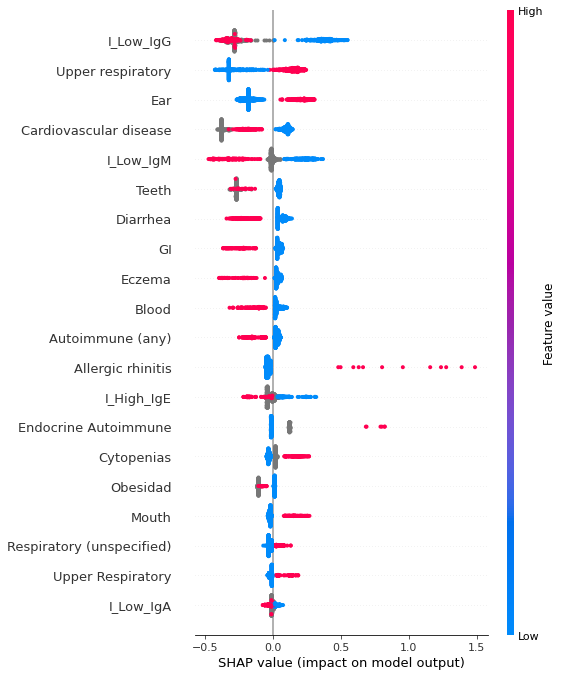

AB Deficiency
117


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9429763560500696

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.942976                0.0
recall                 1.000000                0.0
f1-score               0.970651                0.0
support              678.000000               41.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 1.9695268876096506


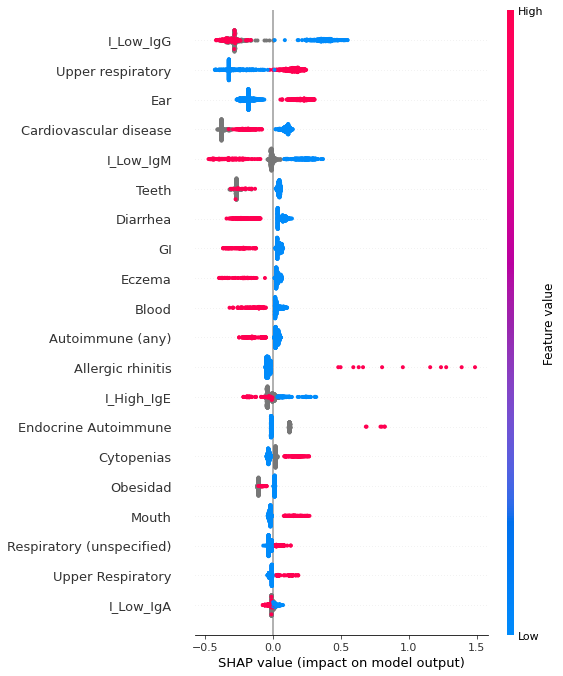

AGAMMA
135
>> The Accuracy on test sample is 0.9513212795549374

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.952314           0.833333
recall                 0.998529           0.128205
f1-score               0.974874           0.222222
support              680.000000          39.000000

>> The Area under the ROC Curve on test sample is 0.563367269984917

>>>>>>>>> Therefore the gini on test sample is 0.12673453996983408

>> The Logloss on test sample is 1.6813045527389492


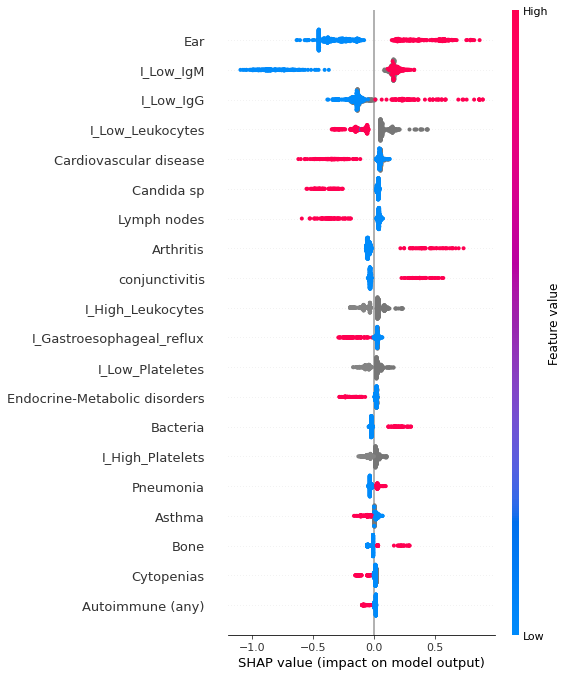

AGAMMA
135
>> The Accuracy on test sample is 0.9513212795549374

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.952314           0.833333
recall                 0.998529           0.128205
f1-score               0.974874           0.222222
support              680.000000          39.000000

>> The Area under the ROC Curve on test sample is 0.563367269984917

>>>>>>>>> Therefore the gini on test sample is 0.12673453996983408

>> The Logloss on test sample is 1.6813045527389492


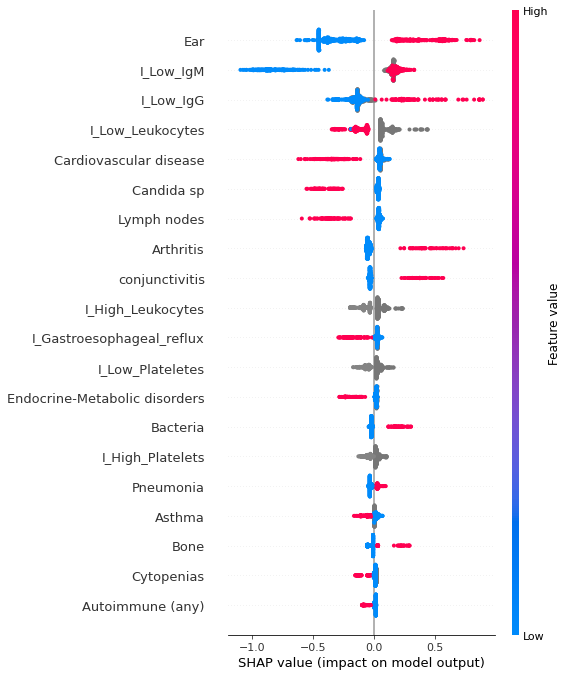

CGD
154
>> The Accuracy on test sample is 0.9499304589707928

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.952924           0.833333
recall                 0.995529           0.312500
f1-score               0.973761           0.454545
support              671.000000          48.000000

>> The Area under the ROC Curve on test sample is 0.6540145305514158

>>>>>>>>> Therefore the gini on test sample is 0.30802906110283157

>> The Logloss on test sample is 1.7293440180932902


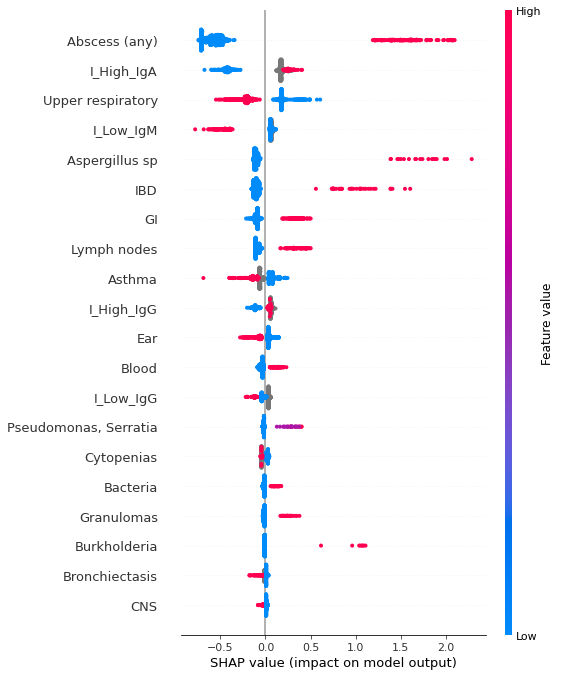

CGD
154
>> The Accuracy on test sample is 0.9499304589707928

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.952924           0.833333
recall                 0.995529           0.312500
f1-score               0.973761           0.454545
support              671.000000          48.000000

>> The Area under the ROC Curve on test sample is 0.6540145305514158

>>>>>>>>> Therefore the gini on test sample is 0.30802906110283157

>> The Logloss on test sample is 1.7293440180932902


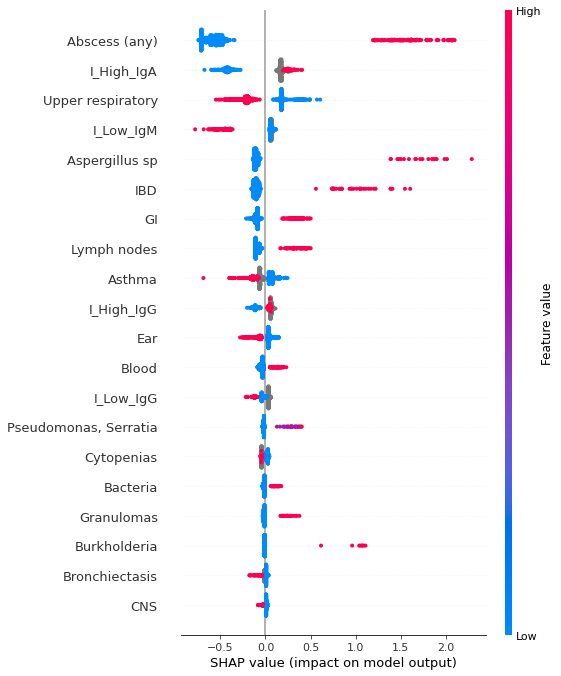

COMPDEF
12


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9972183588317107

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.997218                0.0
recall                 1.000000                0.0
f1-score               0.998607                0.0
support              717.000000                2.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 0.09607448232242292


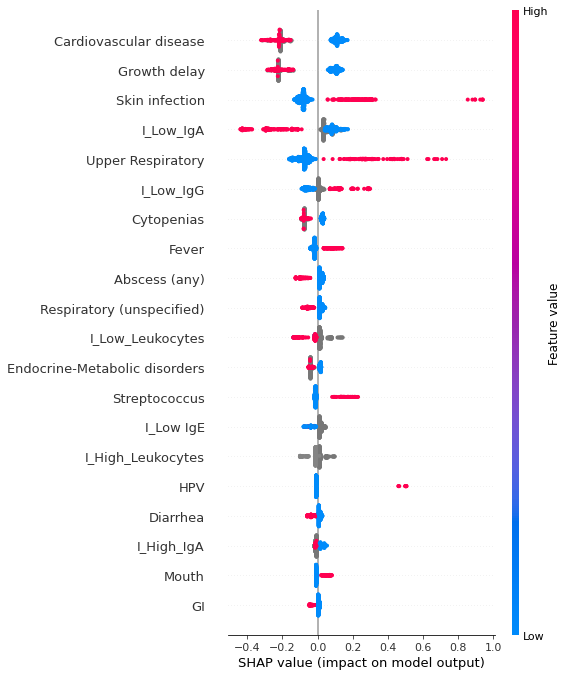

COMPDEF
12


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9972183588317107

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.997218                0.0
recall                 1.000000                0.0
f1-score               0.998607                0.0
support              717.000000                2.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 0.09607448232242292


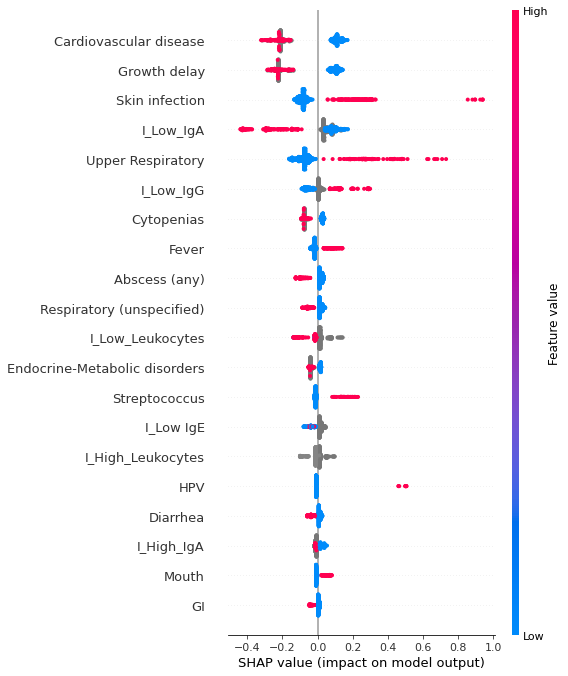

CORE
132
>> The Accuracy on test sample is 0.952712100139082

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.952180           1.000000
recall                 1.000000           0.190476
f1-score               0.975504           0.320000
support              677.000000          42.000000

>> The Area under the ROC Curve on test sample is 0.5952380952380952

>>>>>>>>> Therefore the gini on test sample is 0.19047619047619047

>> The Logloss on test sample is 1.6332661994811735


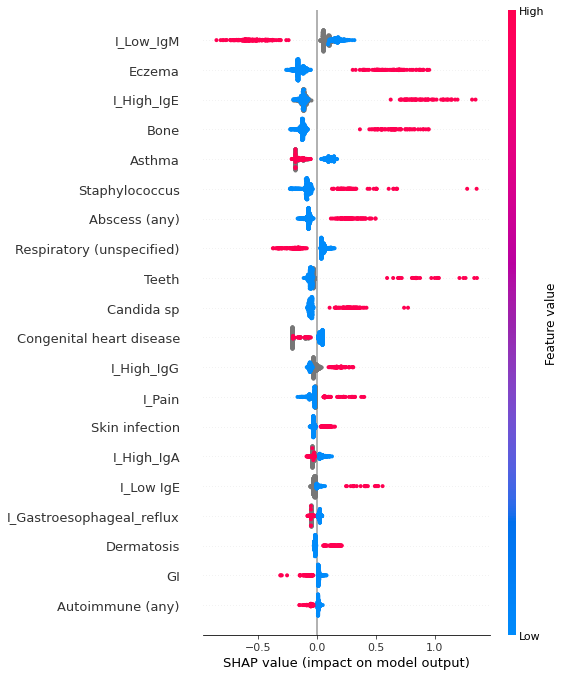

CORE
132
>> The Accuracy on test sample is 0.952712100139082

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.952180           1.000000
recall                 1.000000           0.190476
f1-score               0.975504           0.320000
support              677.000000          42.000000

>> The Area under the ROC Curve on test sample is 0.5952380952380952

>>>>>>>>> Therefore the gini on test sample is 0.19047619047619047

>> The Logloss on test sample is 1.6332661994811735


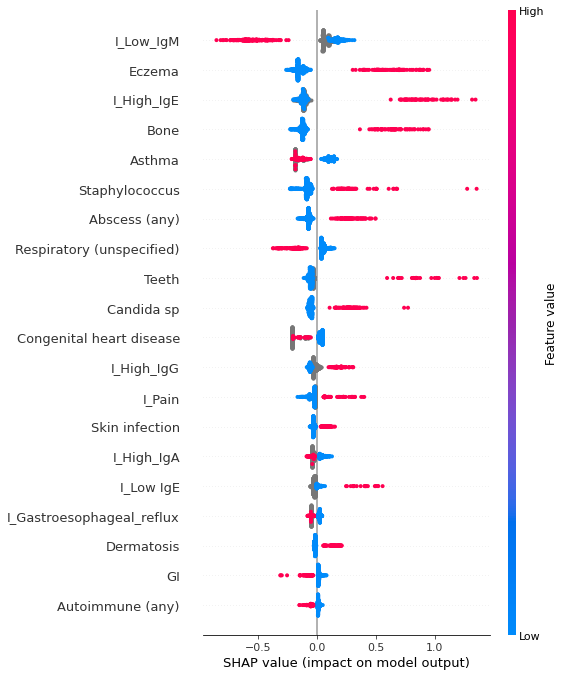

CVID
1098
>> The Accuracy on test sample is 0.7524339360222532

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.778607           0.719243
recall                 0.778607           0.719243
f1-score               0.778607           0.719243
support              402.000000         317.000000

>> The Area under the ROC Curve on test sample is 0.7489249336911656

>>>>>>>>> Therefore the gini on test sample is 0.4978498673823313

>> The Logloss on test sample is 8.550727903289832


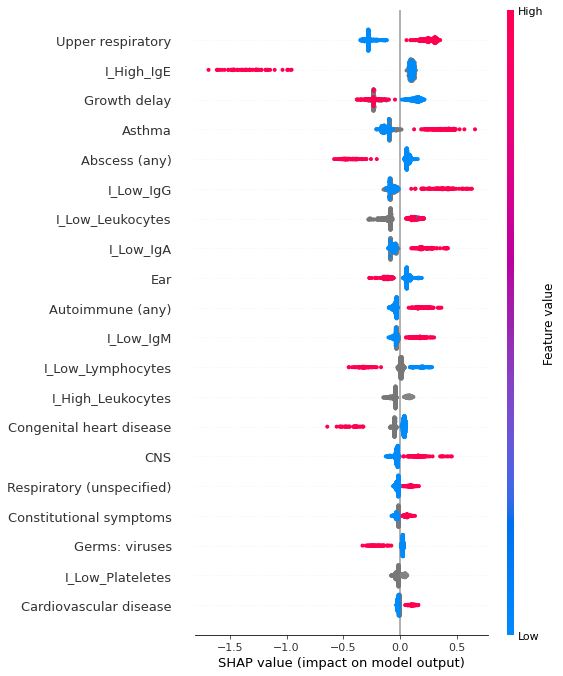

CVID
1098
>> The Accuracy on test sample is 0.7524339360222532

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.778607           0.719243
recall                 0.778607           0.719243
f1-score               0.778607           0.719243
support              402.000000         317.000000

>> The Area under the ROC Curve on test sample is 0.7489249336911656

>>>>>>>>> Therefore the gini on test sample is 0.4978498673823313

>> The Logloss on test sample is 8.550727903289832


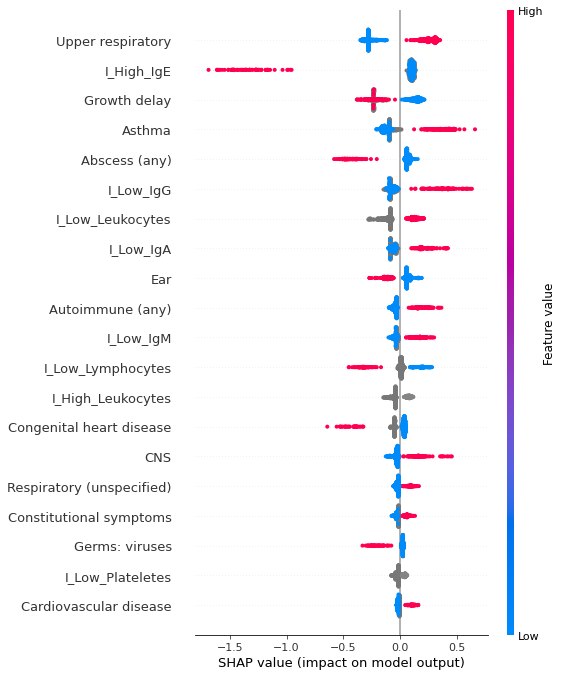

DGS
406
>> The Accuracy on test sample is 0.8970792767732962

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.964286           0.660377
recall                 0.909091           0.840000
f1-score               0.935875           0.739437
support              594.000000         125.000000

>> The Area under the ROC Curve on test sample is 0.8745454545454545

>>>>>>>>> Therefore the gini on test sample is 0.749090909090909

>> The Logloss on test sample is 3.554815899144119


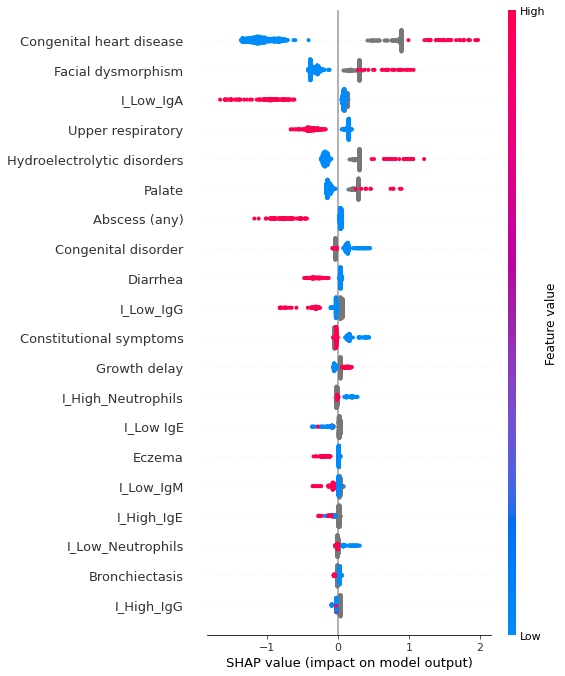

DGS
406
>> The Accuracy on test sample is 0.8970792767732962

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.964286           0.660377
recall                 0.909091           0.840000
f1-score               0.935875           0.739437
support              594.000000         125.000000

>> The Area under the ROC Curve on test sample is 0.8745454545454545

>>>>>>>>> Therefore the gini on test sample is 0.749090909090909

>> The Logloss on test sample is 3.554815899144119


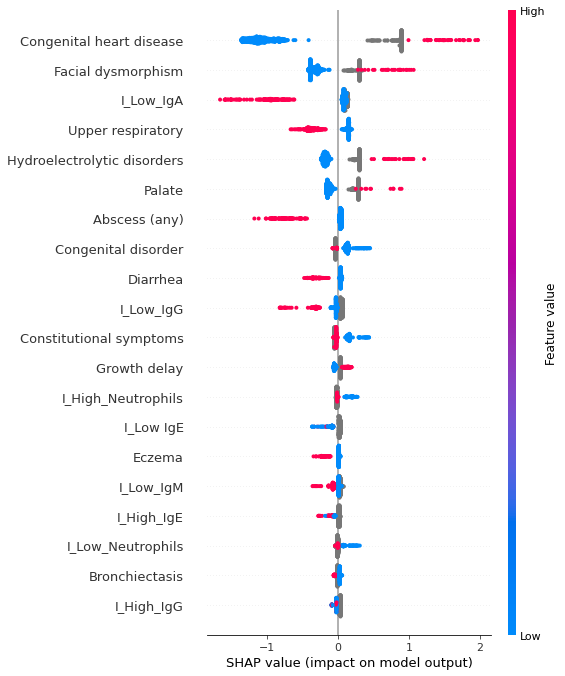

HIGM
46


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9847009735744089

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.984701                0.0
recall                 1.000000                0.0
f1-score               0.992292                0.0
support              708.000000               11.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 0.5284096527733214


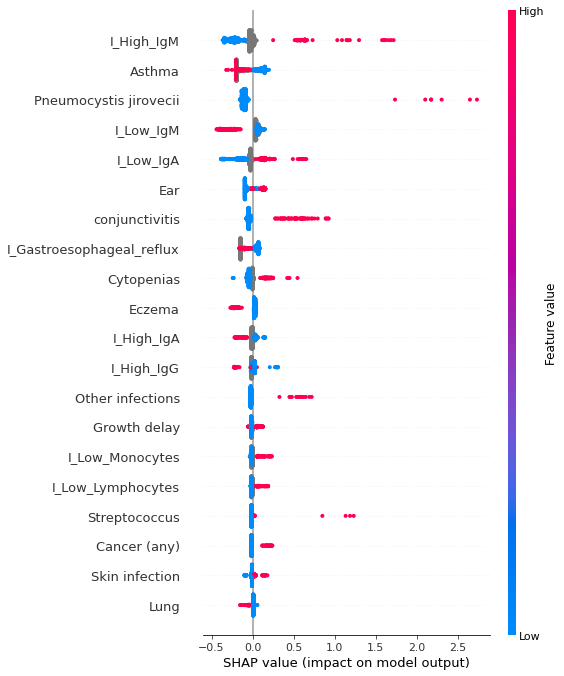

HIGM
46


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9847009735744089

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.984701                0.0
recall                 1.000000                0.0
f1-score               0.992292                0.0
support              708.000000               11.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 0.5284096527733214


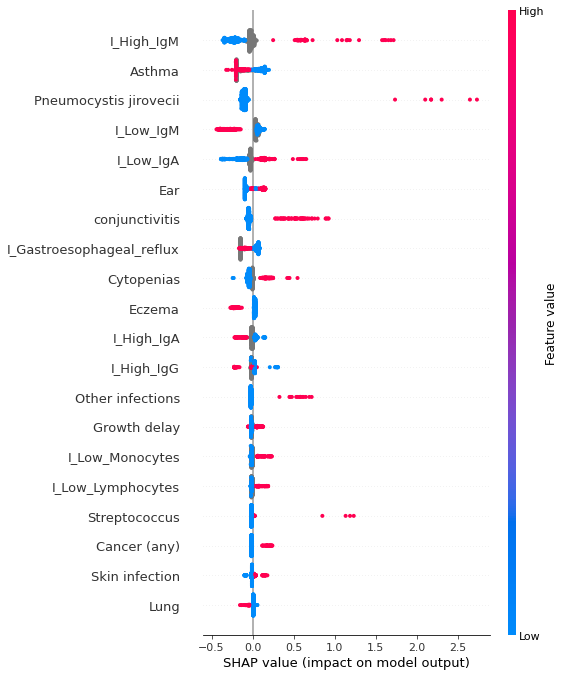

LAD
6


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9958275382475661

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.995828                0.0
recall                 1.000000                0.0
f1-score               0.997909                0.0
support              716.000000                3.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 0.14411172348363388


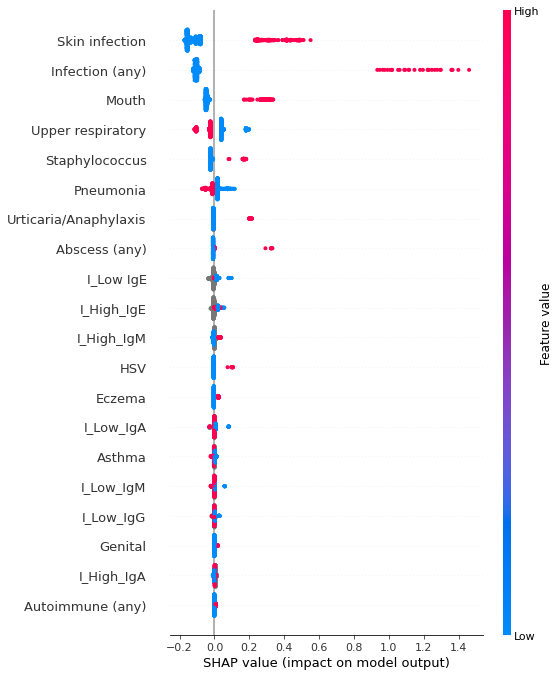

LAD
6


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


>> The Accuracy on test sample is 0.9958275382475661

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.995828                0.0
recall                 1.000000                0.0
f1-score               0.997909                0.0
support              716.000000                3.0

>> The Area under the ROC Curve on test sample is 0.5

>>>>>>>>> Therefore the gini on test sample is 0.0

>> The Logloss on test sample is 0.14411172348363388


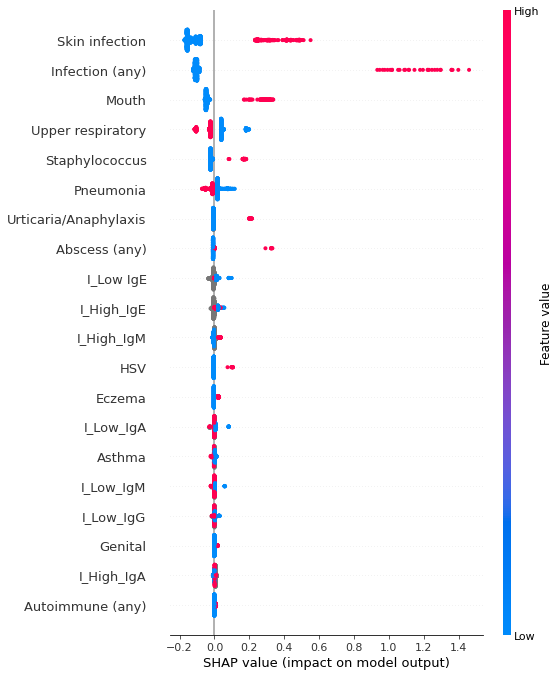

NEMO
25
>> The Accuracy on test sample is 0.9847009735744089

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.984680           1.000000
recall                 1.000000           0.083333
f1-score               0.992281           0.153846
support              707.000000          12.000000

>> The Area under the ROC Curve on test sample is 0.5416666666666666

>>>>>>>>> Therefore the gini on test sample is 0.08333333333333326

>> The Logloss on test sample is 0.5284096527733216


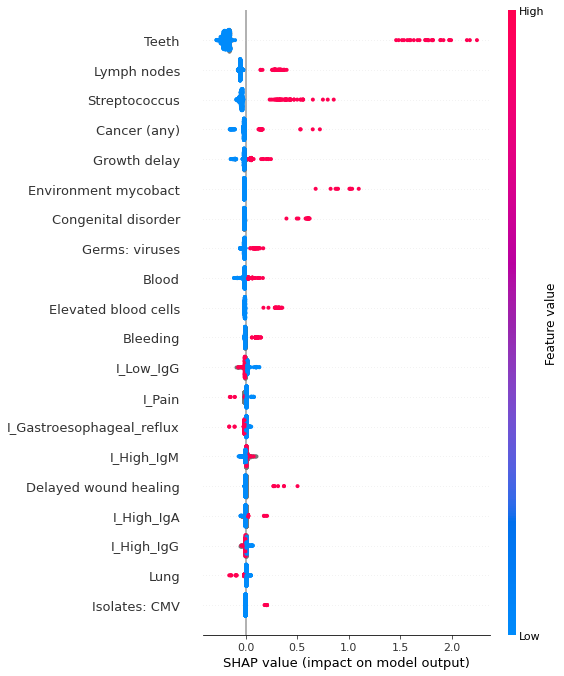

NEMO
25
>> The Accuracy on test sample is 0.9847009735744089

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.984680           1.000000
recall                 1.000000           0.083333
f1-score               0.992281           0.153846
support              707.000000          12.000000

>> The Area under the ROC Curve on test sample is 0.5416666666666666

>>>>>>>>> Therefore the gini on test sample is 0.08333333333333326

>> The Logloss on test sample is 0.5284096527733216


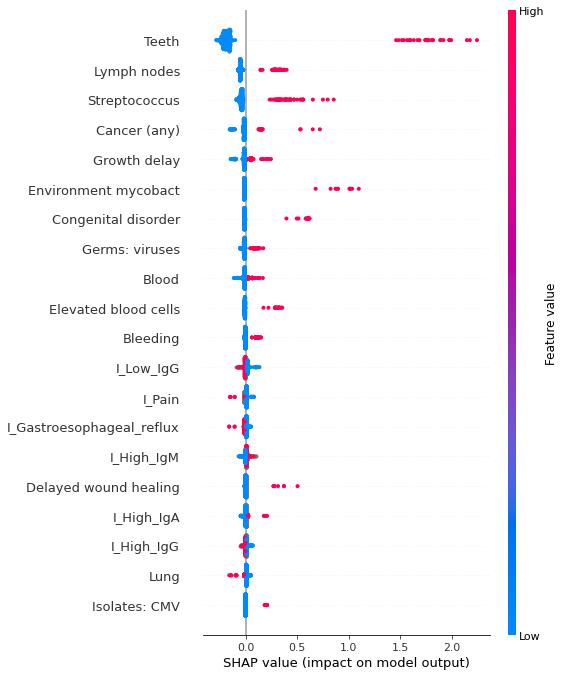

SCID
202
>> The Accuracy on test sample is 0.9165507649513213

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.919944           0.571429
recall                 0.995441           0.065574
f1-score               0.956204           0.117647
support              658.000000          61.000000

>> The Area under the ROC Curve on test sample is 0.5305072499875431

>>>>>>>>> Therefore the gini on test sample is 0.06101449997508612

>> The Logloss on test sample is 2.8822378059623532


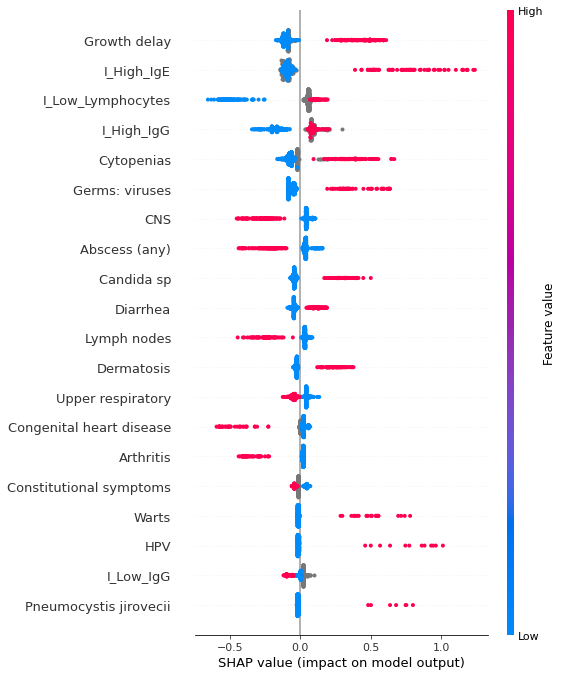

SCID
202
>> The Accuracy on test sample is 0.9165507649513213

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.919944           0.571429
recall                 0.995441           0.065574
f1-score               0.956204           0.117647
support              658.000000          61.000000

>> The Area under the ROC Curve on test sample is 0.5305072499875431

>>>>>>>>> Therefore the gini on test sample is 0.06101449997508612

>> The Logloss on test sample is 2.8822378059623532


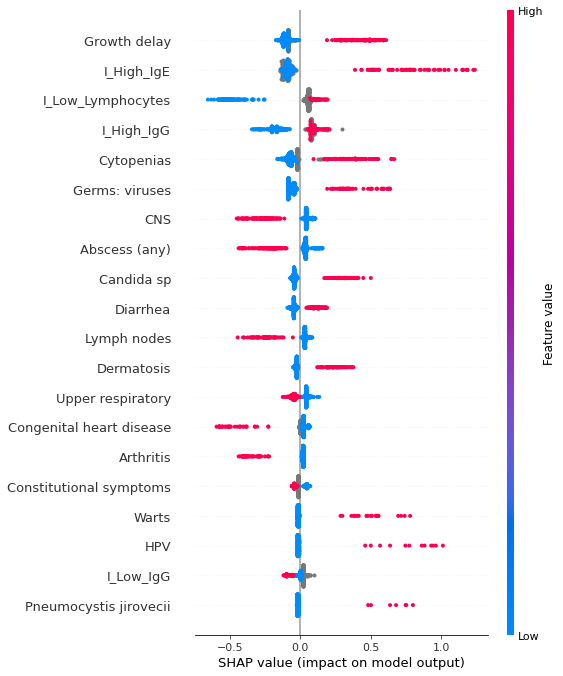

WAS
63
>> The Accuracy on test sample is 0.9763560500695411

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.976323           1.000000
recall                 1.000000           0.055556
f1-score               0.988020           0.105263
support              701.000000          18.000000

>> The Area under the ROC Curve on test sample is 0.5277777777777778

>>>>>>>>> Therefore the gini on test sample is 0.05555555555555558

>> The Logloss on test sample is 0.8166330997405873


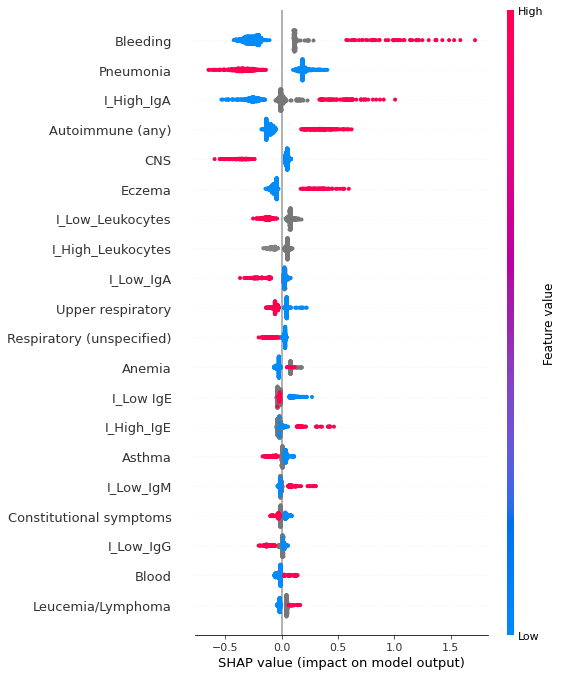

WAS
63
>> The Accuracy on test sample is 0.9763560500695411

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.976323           1.000000
recall                 1.000000           0.055556
f1-score               0.988020           0.105263
support              701.000000          18.000000

>> The Area under the ROC Curve on test sample is 0.5277777777777778

>>>>>>>>> Therefore the gini on test sample is 0.05555555555555558

>> The Logloss on test sample is 0.8166330997405873


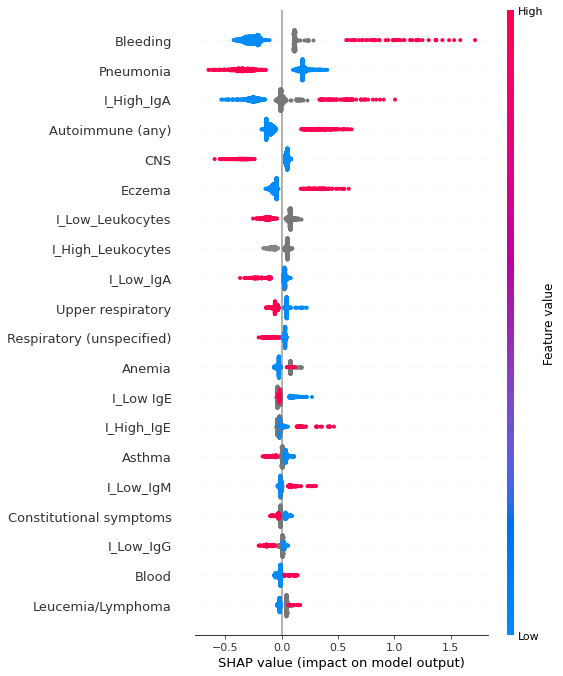

In [ ]:
list_res = []
for target_num in list(set(data['pre_target'])):
    listreports=run_model_DX(data,target_num)
    list_res = list_res + [run_model_DX(data,target_num)]

## Scaling the objective

AB Deficiency
117
>> The Accuracy on test sample is 0.8386648122392212

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.974662           0.204724
recall                 0.851032           0.634146
f1-score               0.908661           0.309524
support              678.000000          41.000000

>> The Area under the ROC Curve on test sample is 0.7425893949204979

>>>>>>>>> Therefore the gini on test sample is 0.4851787898409958

>> The Logloss on test sample is 5.572432296453532


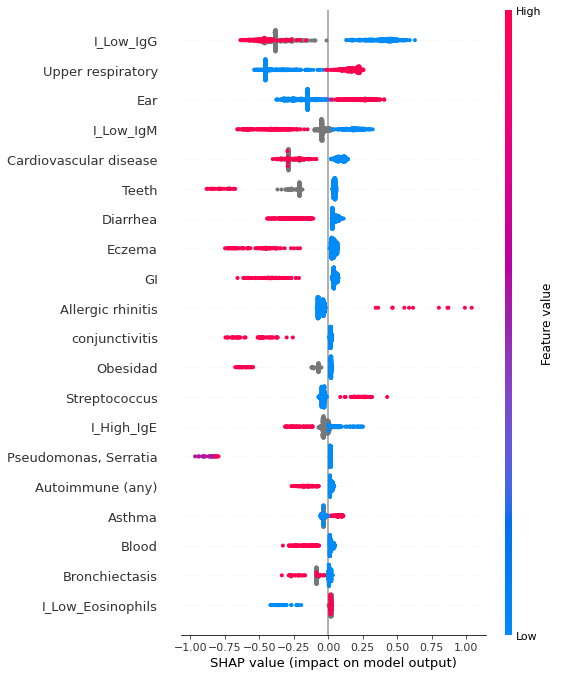

AGAMMA
135
>> The Accuracy on test sample is 0.8887343532684284

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.976190           0.269663
recall                 0.904412           0.615385
f1-score               0.938931           0.375000
support              680.000000          39.000000

>> The Area under the ROC Curve on test sample is 0.759898190045249

>>>>>>>>> Therefore the gini on test sample is 0.5197963800904979

>> The Logloss on test sample is 3.8430515791735984


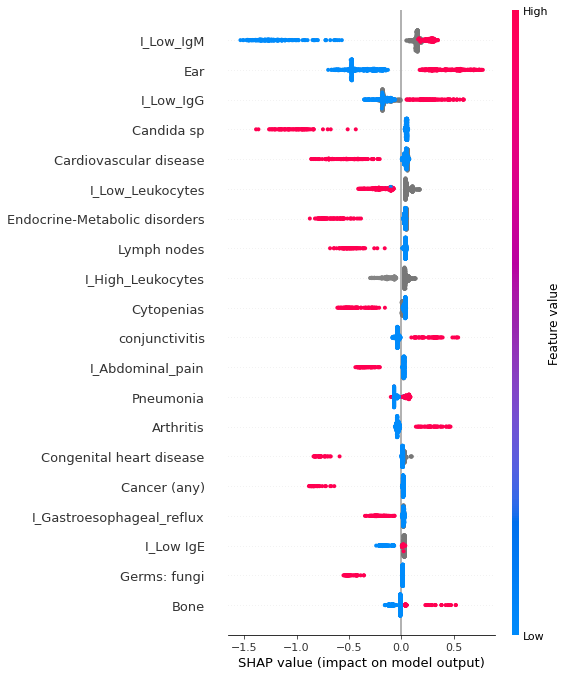

CGD
154
>> The Accuracy on test sample is 0.9221140472878998

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.979719           0.448718
recall                 0.935917           0.729167
f1-score               0.957317           0.555556
support              671.000000          48.000000

>> The Area under the ROC Curve on test sample is 0.8325416045702931

>>>>>>>>> Therefore the gini on test sample is 0.6650832091405863

>> The Logloss on test sample is 2.690133325180107


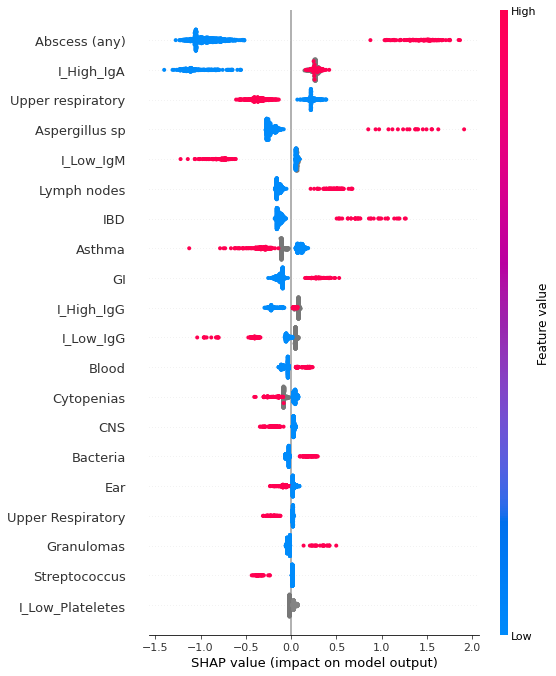

COMPDEF
12
>> The Accuracy on test sample is 0.9235048678720446

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.996997                0.0
recall                 0.926081                0.0
f1-score               0.960231                0.0
support              717.000000                2.0

>> The Area under the ROC Curve on test sample is 0.4630404463040446

>>>>>>>>> Therefore the gini on test sample is -0.07391910739191077

>> The Logloss on test sample is 2.642107204984546


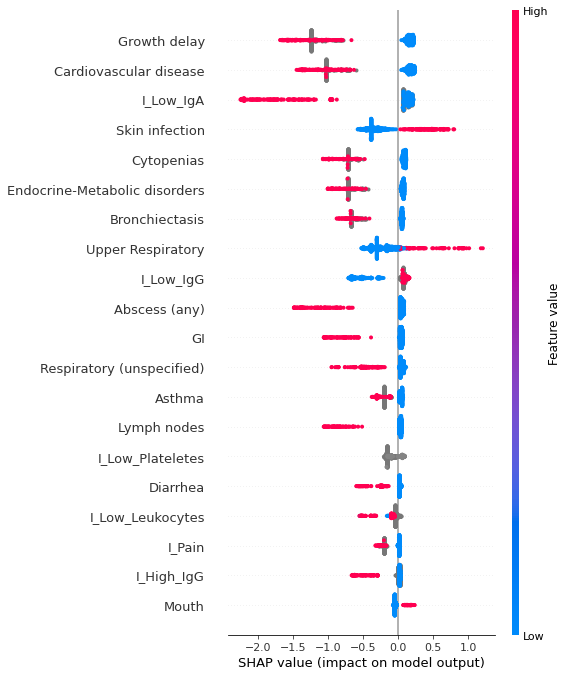

CORE
132
>> The Accuracy on test sample is 0.8789986091794159

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.969745           0.252747
recall                 0.899557           0.547619
f1-score               0.933333           0.345865
support              677.000000          42.000000

>> The Area under the ROC Curve on test sample is 0.7235879580783569

>>>>>>>>> Therefore the gini on test sample is 0.4471759161567137

>> The Logloss on test sample is 4.17931560359177


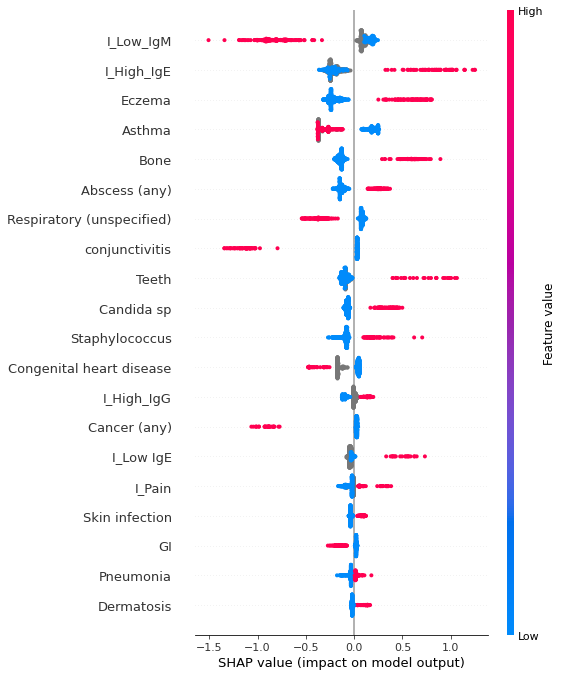

CVID
1098
>> The Accuracy on test sample is 0.7496522948539638

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.793651           0.700880
recall                 0.746269           0.753943
f1-score               0.769231           0.726444
support              402.000000         317.000000

>> The Area under the ROC Curve on test sample is 0.7501059371910165

>>>>>>>>> Therefore the gini on test sample is 0.500211874382033

>> The Logloss on test sample is 8.646816842867599


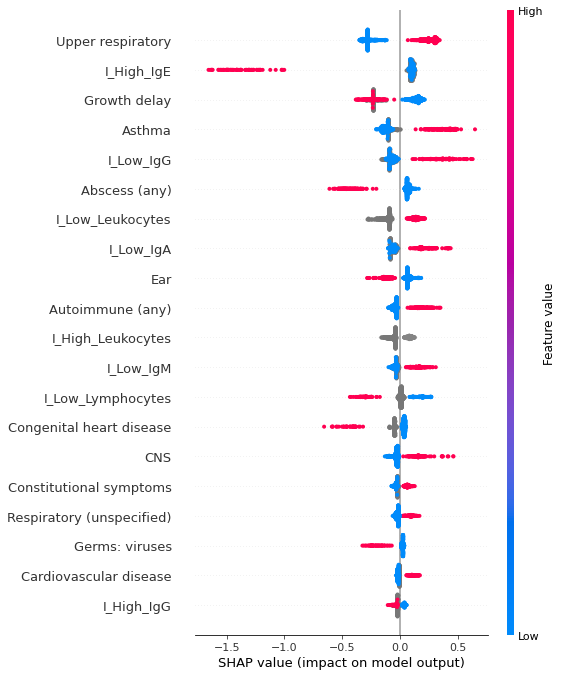

DGS
406
>> The Accuracy on test sample is 0.8845618915159944

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.975791           0.615385
recall                 0.882155           0.896000
f1-score               0.926614           0.729642
support              594.000000         125.000000

>> The Area under the ROC Curve on test sample is 0.889077441077441

>>>>>>>>> Therefore the gini on test sample is 0.778154882154882

>> The Logloss on test sample is 3.9871688631400564


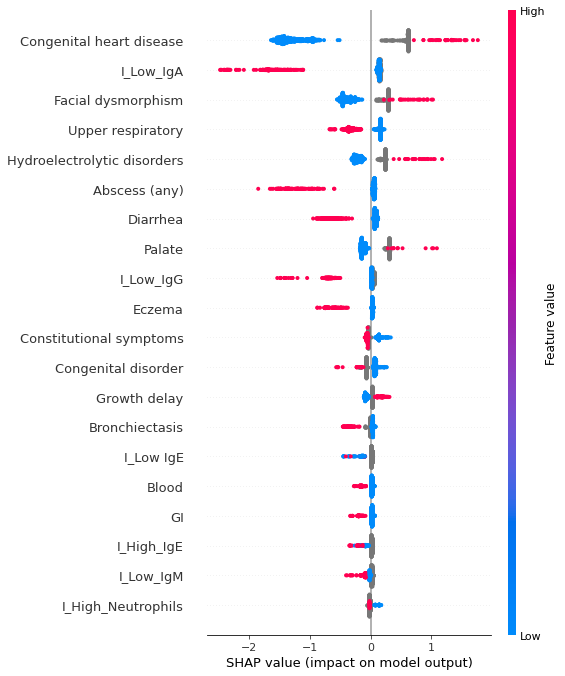

HIGM
46
>> The Accuracy on test sample is 0.9248956884561892

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.989521           0.078431
recall                 0.933616           0.363636
f1-score               0.960756           0.129032
support              708.000000          11.000000

>> The Area under the ROC Curve on test sample is 0.6486260914227017

>>>>>>>>> Therefore the gini on test sample is 0.29725218284540333

>> The Logloss on test sample is 2.594063291243945


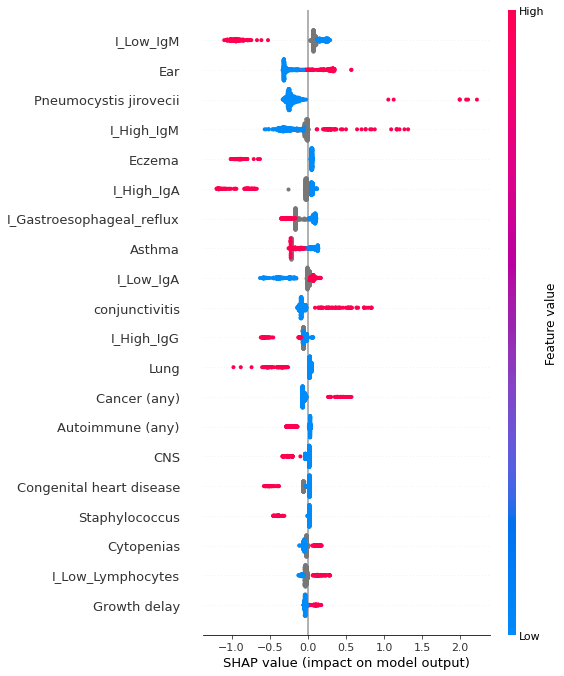

LAD
6
>> The Accuracy on test sample is 0.9972183588317107

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.997214           1.000000
recall                 1.000000           0.333333
f1-score               0.998605           0.500000
support              716.000000           3.000000

>> The Area under the ROC Curve on test sample is 0.6666666666666666

>>>>>>>>> Therefore the gini on test sample is 0.33333333333333326

>> The Logloss on test sample is 0.09607448232242292


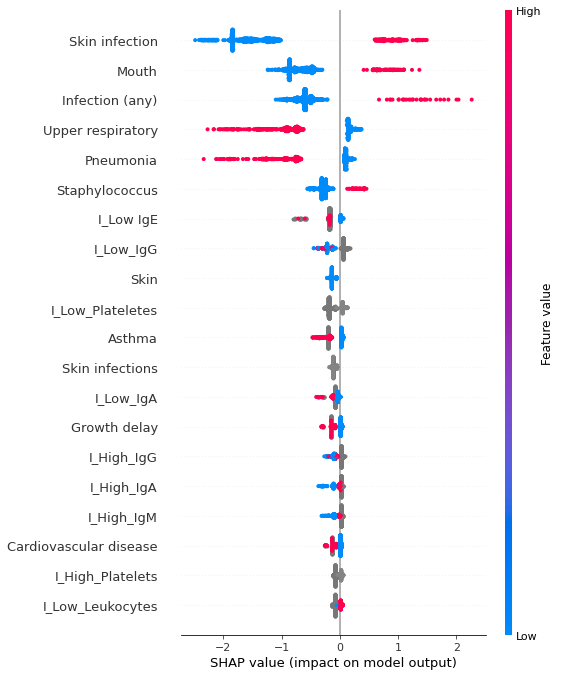

NEMO
25
>> The Accuracy on test sample is 0.9707927677329624

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.987216           0.200000
recall                 0.983027           0.250000
f1-score               0.985117           0.222222
support              707.000000          12.000000

>> The Area under the ROC Curve on test sample is 0.6165134370579916

>>>>>>>>> Therefore the gini on test sample is 0.2330268741159831

>> The Logloss on test sample is 1.0087954095442104


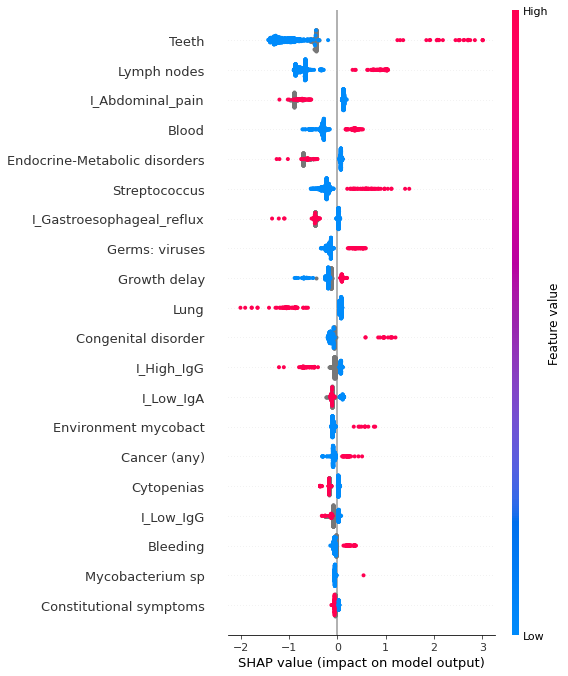

SCID
202
>> The Accuracy on test sample is 0.8511821974965229

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.958403           0.305085
recall                 0.875380           0.590164
f1-score               0.915012           0.402235
support              658.000000          61.000000

>> The Area under the ROC Curve on test sample is 0.7327719368179779

>>>>>>>>> Therefore the gini on test sample is 0.46554387363595584

>> The Logloss on test sample is 5.140075996167899


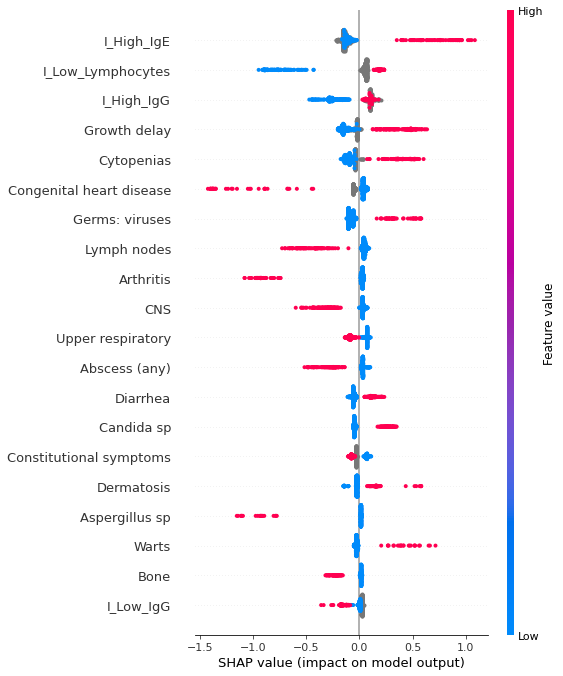

WAS
63
>> The Accuracy on test sample is 0.7593880389429764

>> The Precision-Recall on test sample is 
           Class without the DX  Class with the DX
precision              0.990706           0.071823
recall                 0.760342           0.722222
f1-score               0.860371           0.130653
support              701.000000          18.000000

>> The Area under the ROC Curve on test sample is 0.7412822951339357

>>>>>>>>> Therefore the gini on test sample is 0.48256459026787146

>> The Logloss on test sample is 8.310629553112408


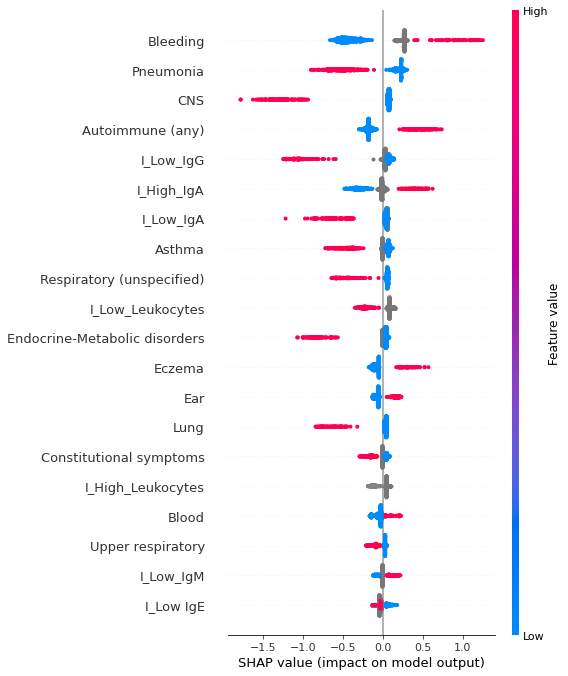

In [ ]:
list_res_scale = []
for target_num in list(set(data['pre_target'])):
    list_res_scale = list_res_scale + [run_model_DX(data,target_num,scale=True)]

In [ ]:
# [[model,shaps_values,shap_importance,X_train,y_train,X_test,y_test]]
i=0
top_features = {}
for i in range(len(list_res_scale)):
  varobj = data[data['pre_target']==i].Category.tolist()[0]
  top_features[varobj] = list_res_scale[i][2].head(10).feature.tolist()

In [ ]:
top_features

{'AB Deficiency': ['I_Low_IgG',
  'Upper respiratory',
  'Ear',
  'I_Low_IgM',
  'Cardiovascular disease',
  'Teeth',
  'Diarrhea',
  'Eczema',
  'GI',
  'Allergic rhinitis'],
 'AGAMMA': ['I_Low_IgM',
  'Ear',
  'I_Low_IgG',
  'Candida sp',
  'Cardiovascular disease',
  'I_Low_Leukocytes',
  'Endocrine-Metabolic disorders',
  'Lymph nodes',
  'I_High_Leukocytes',
  'Cytopenias'],
 'CGD': ['Abscess (any)',
  'I_High_IgA',
  'Upper respiratory',
  'Aspergillus sp',
  'I_Low_IgM',
  'Lymph nodes',
  'IBD',
  'Asthma',
  'GI',
  'I_High_IgG'],
 'COMPDEF': ['Growth delay',
  'Cardiovascular disease',
  'I_Low_IgA',
  'Skin infection',
  'Cytopenias',
  'Endocrine-Metabolic disorders',
  'Bronchiectasis',
  'Upper Respiratory',
  'I_Low_IgG',
  'Abscess (any)'],
 'CORE': ['I_Low_IgM',
  'I_High_IgE',
  'Eczema',
  'Asthma',
  'Bone',
  'Abscess (any)',
  'Respiratory (unspecified)',
  'conjunctivitis',
  'Teeth',
  'Candida sp'],
 'CVID': ['Upper respiratory',
  'I_High_IgE',
  'Growth delay